# Tugas Akhir Pelatihan Ai 
Tugas Akhir ini adalah Program Digit Recognetion
Dataset yang digunakan bersumber dari Kaggle.
Dataset dapat diunduh melalui link Drive https://drive.google.com/file/d/1XS9F7NYdIYCkzWg0BpTlBF17HPf3N039/view?usp=sharing



In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, models
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# coba ambil data csv
dataset = pd.read_csv('drive/My Drive/dataset.csv')

In [ ]:
dataset.shape

(42000, 785)

In [ ]:
len(dataset)

42000

In [ ]:
dataset.tail()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Training on CPU...')
else:
    print('Training on GPU...')

Training on CPU...


In [ ]:
class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
                
        gambar = item[1:].values.astype(np.uint8).reshape((28, 28))
        label = item[0]
        
        if self.transform is not None:
            gambar = self.transform(gambar)
            
        return gambar, label

In [ ]:
BATCH_SIZE = 100
VALID_SIZE = 0.15 

transform_train = transforms.Compose([
    transforms.ToPILImage(),
   
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

transform_valid = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [ ]:
# buat dataset untuk train dan test
train_data = DatasetMNIST(dataset, transform=transform_train)
valid_data = DatasetMNIST(dataset, transform=transform_valid)

In [ ]:
# Mengacak data dan memilih data yang akan digunakan untuk pelatihan dan validasi
num_train = len(train_data)
indek = list(range(num_train))
np.random.shuffle(indek)
split = int(np.floor(VALID_SIZE * num_train))
train_idx, valid_idx = indek[split:], indek[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, sampler=valid_sampler)

In [ ]:
print(f"Jumlah Train: {len(train_idx)}")
print(f"Jumlah Valid: {len(valid_idx)}")

Jumlah Train: 35700
Jumlah Valid: 6300


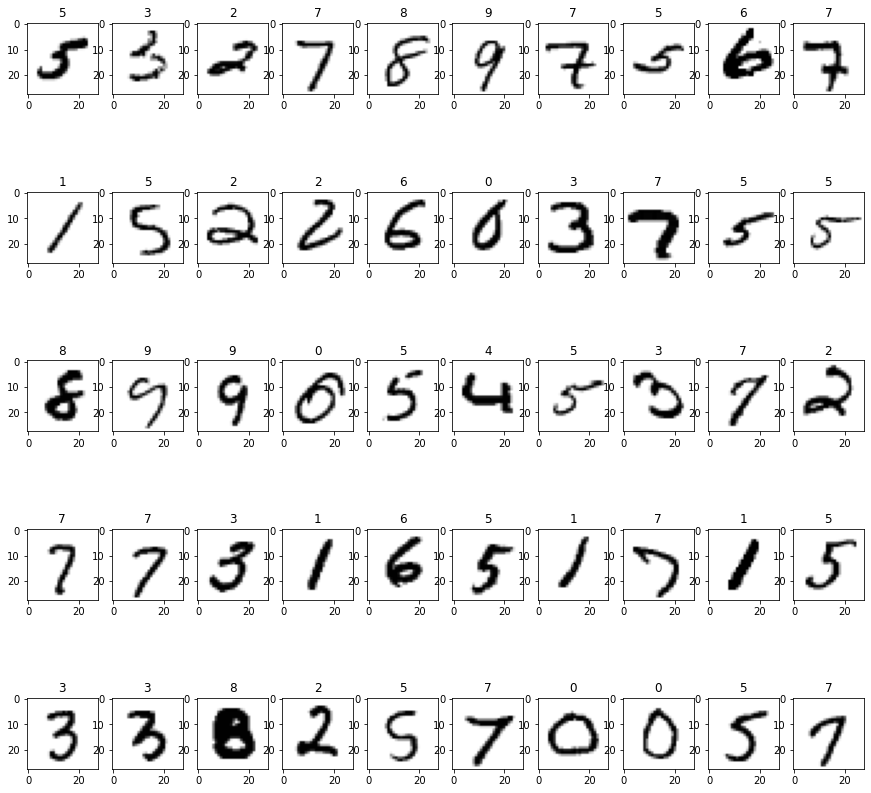

In [ ]:
# Lihat Hasil Train
fig, axis = plt.subplots(5, 10, figsize=(15, 15))
images, labels = next(iter(train_loader))

for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]

        ax.imshow(image.view(28, 28), cmap='binary') 
        ax.set(title = f"{label}") 

In [ ]:
#BUAT MODEL NN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128, 10),
        )
                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = Net()
print(model)

if train_on_gpu:
    model.cuda()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p

In [ ]:
LEARNING_RATE = 0.001720
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [ ]:
epochs = 7
valid_loss_min = np.Inf
train_losses, valid_losses = [], []
history_accuracy = []
 
for e in range(1, epochs+1):
    running_loss = 0
 
    for images, labels in train_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
       
        optimizer.zero_grad()
        ps = model(images)
        loss = criterion(ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        valid_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval() 
            for images, labels in valid_loader:
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                ps = model(images)
                _, top_class = ps.topk(1, dim=1)
                
                equals = top_class == labels.view(*top_class.shape)
                
                valid_loss += criterion(ps, labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))
        history_accuracy.append(accuracy/len(valid_loader))
        
        network_learned = valid_loss < valid_loss_min
 
        if e == 1 or e % 5 == 0 or network_learned:
            print(f"Epoch: {e}/{epochs}.. ",
                  f"Training Loss: {running_loss/len(train_loader):.3f}.. ",
                  f"Validation Loss: {valid_loss/len(valid_loader):.3f}.. ",
                  f"Test Accuracy: {accuracy/len(valid_loader):.3f}")

Epoch: 1/7..  Training Loss: 1.338..  Validation Loss: 0.509..  Test Accuracy: 0.877
Epoch: 2/7..  Training Loss: 0.569..  Validation Loss: 0.280..  Test Accuracy: 0.927
Epoch: 3/7..  Training Loss: 0.386..  Validation Loss: 0.199..  Test Accuracy: 0.946
Epoch: 4/7..  Training Loss: 0.298..  Validation Loss: 0.157..  Test Accuracy: 0.953
Epoch: 5/7..  Training Loss: 0.252..  Validation Loss: 0.135..  Test Accuracy: 0.960
Epoch: 6/7..  Training Loss: 0.217..  Validation Loss: 0.116..  Test Accuracy: 0.964
Epoch: 7/7..  Training Loss: 0.195..  Validation Loss: 0.104..  Test Accuracy: 0.968


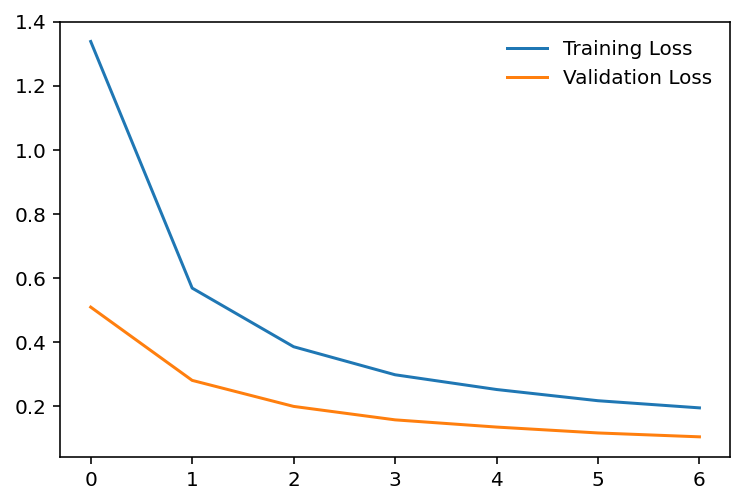

In [ ]:
#   Buat Plot untuk menampilkan informasi train loss dan valid loss
%matplotlib inline
%config InlineBackend.figure_format = 'retina'



plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend(frameon=False)

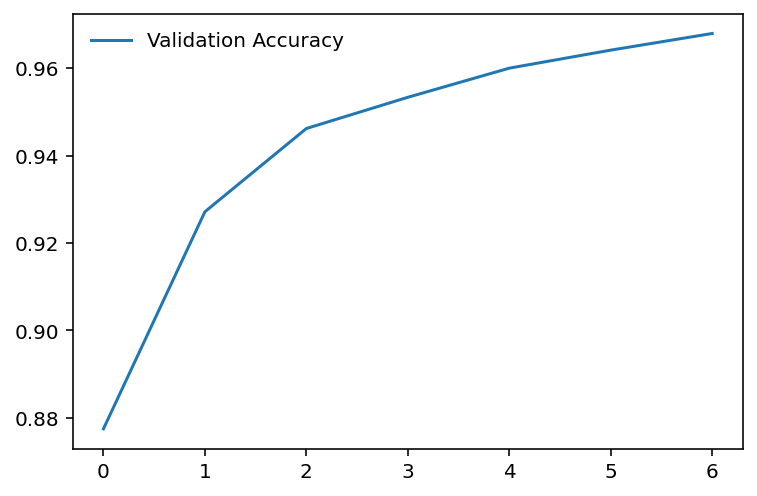

In [ ]:
# Membuat Plot dengan label pencapaian akurasi
plt.plot(history_accuracy, label='Validation Accuracy')
plt.legend(frameon=False)

In [ ]:
classes = ['0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9']
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()

for data, target in valid_loader:
    
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target) #menghitung loss pada batch 
    test_loss += loss.item()*data.size(0) #update test lost
    
    _, pred = torch.max(output, 1)  # Mengubah Probabilitas class yang diprediksi
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(BATCH_SIZE):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

In [ ]:
#Perbandingan Test Loss dan Akurasi
test_loss = test_loss/len(valid_loader.dataset)
print('Berapa Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Hasil Akurasi Program %5s: %0.4f%% (%2d/%2d)' % (
            classes[i], class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s:' % (classes[i]))

print('\n Akurasi (TOTAL): %2.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Berapa Test Loss: 0.015636

Hasil Akurasi Program     0: 0.9887% (610/617)
Hasil Akurasi Program     1: 0.9853% (670/680)
Hasil Akurasi Program     2: 0.9652% (582/603)
Hasil Akurasi Program     3: 0.9625% (641/666)
Hasil Akurasi Program     4: 0.9638% (585/607)
Hasil Akurasi Program     5: 0.9629% (571/593)
Hasil Akurasi Program     6: 0.9780% (622/636)
Hasil Akurasi Program     7: 0.9659% (623/645)
Hasil Akurasi Program     8: 0.9467% (586/619)
Hasil Akurasi Program     9: 0.9590% (608/634)

 Akurasi (TOTAL): 96.79% (6098/6300)
